In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy as np

In [0]:
device = torch.device('cuda:0')

In [0]:
batch_size = 64

In [0]:
def get_loader(train):
    dataset = datasets.MNIST('mnist', train=train, download=True, 
                             transform=transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         shuffle=True)
    return loader

train = get_loader(True)
val = get_loader(False)

Processing...
Done!


In [0]:
D_in = 784
H = 784
D_out = 10
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(H, D_out),
    nn.LogSoftmax(dim=1)
)
model = model.to(device)

In [0]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.to(device)
        y = y.to(device)
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

0.99405 0.9818


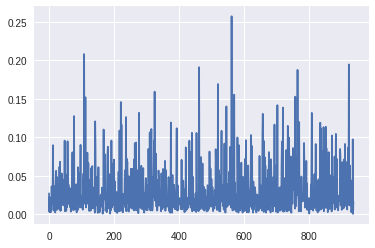

0.9954 0.9814


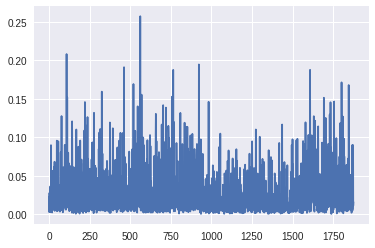

0.9969666666666667 0.9826


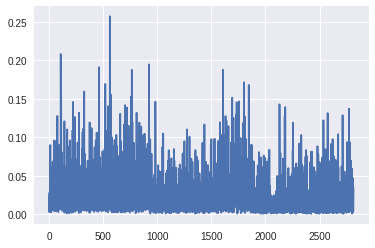

0.99775 0.983


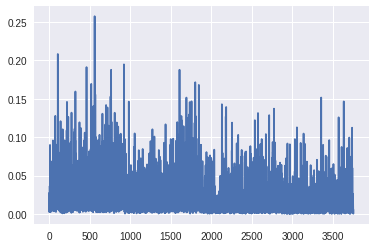

0.9970833333333333 0.981


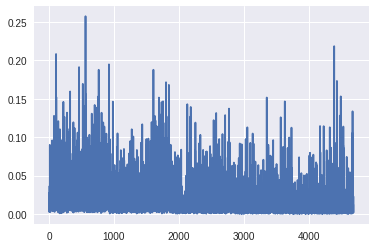

0.9965333333333334 0.9813


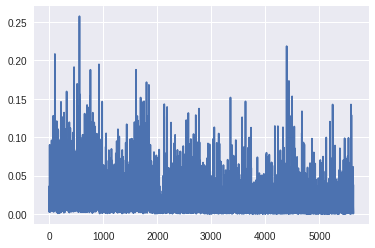

0.9978 0.9821


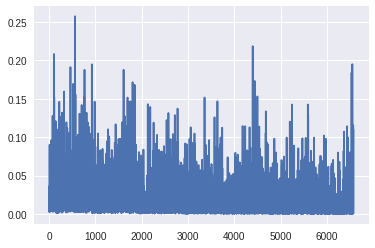

0.99835 0.9828


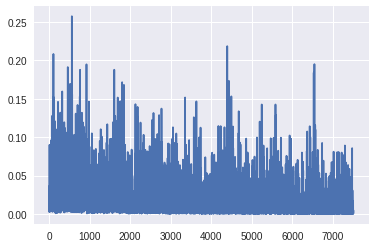

0.9977 0.9828


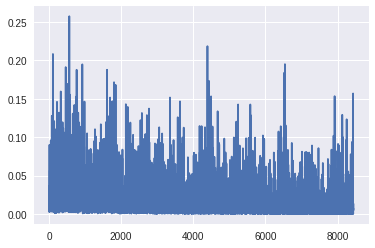

0.9981 0.9821


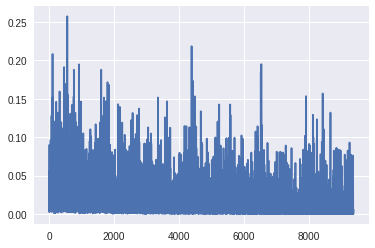

In [0]:
train_losses = []
for epoch in range(10):
    model = model.train()
    
    for X, y in train:
        X = X.to(device)
        y = y.to(device)
        
        X = X.view(-1, 784)
        
        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())
        
        optimizer.step()
    
    model = model.eval()
    
    print(accuracy(model, train), accuracy(model, val))
    
    plt.plot(train_losses)
    plt.show()

In [0]:
def get(x):
    return train.dataset[x][0].view(1, 784).to(device)

def imshow(img):
    pic = img.detach().cpu().numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    latent = [model.encode(get(k)).data.to(device) for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        a = a.to(device)
        b = b.to(device)
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

In [0]:
def Block(d_in, d_out):
  return nn.Sequential(
      nn.Linear(d_in, d_out),
  );

def Block_tanh(d_in, d_out):
  return nn.Sequential(
      Block(d_in, d_out),
      nn.Tanh()
  );

def Block_relu(d_in, d_out):
  return nn.Sequential(
      Block(d_in, d_out),
      nn.ReLU()
  );

def Block_sigmoid(d_in, d_out):
  return nn.Sequential(
      Block(d_in, d_out),
      nn.Sigmoid()
  );

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        H0 = 784
        H1 = 128
        H2 = 64
        H3 = 2
        
        self.encode = nn.Sequential(
            Block_relu(H0, H1),
            Block_relu(H1, H2),
            Block_relu(H2, H3),
        )
        
        self.decode = nn.Sequential(
            Block_relu(H3, H2),
            Block_relu(H2, H1),
            Block_sigmoid(H1, H0),
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
train_losses = []
for epoch in range(100):
    for data, _ in tqdm(train, position=0):
        data = data.to(device)
        data = data.view(-1, 784)
        data = data
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss = loss.item()
        optimizer.step()
    
        train_losses.append(train_loss)
    
    
    plt.plot(train_losses)
    
    plt.figure(figsize=(10, 10))
    
    t = np.random.randint(0, len(val.dataset))
    X = val.dataset[t][0]
    X = X.to(device)
    
    plt.subplot(121)
    imshow(X[0])
    
    y = model(X.view(1, 1, 784))[0].view(28, 28)
    
    plt.subplot(122)
    imshow(y)
    
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

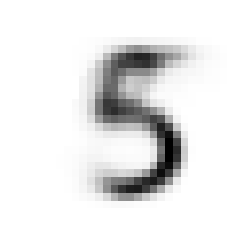

In [11]:
morph(np.random.randint(0, len(train.dataset), 30), 20, 30)

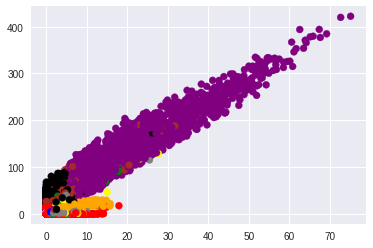

In [14]:
crd_x = []
crd_y = []
crd_c = []
colors = ['red', 'blue', 'green', 'yellow', 'black', 'gray', 'orange', 'purple', 'pink', 'brown']
for X, y in train:
  X = X.to(device)
  y = y.to(device)
  
  X = X.view(-1, 784)
  
  states = model.encode(X).detach().cpu().numpy()
  
  for i in range(len(states)):
    a, b = states[i]
    crd_x.append(a)
    crd_y.append(b)
    crd_c.append(colors[y[i]])

plt.scatter(crd_x, crd_y, c=crd_c)
plt.show()